In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)



def plot_embed_with_label(dfp, label_col = ['cancer_type'],  label_type = ['c'], orders = [None],
                          figsize=(10,10), metric='correlation',  
                          n_neighbors=20, min_dist = 0.5, spread = 1, s = 4, random_state = 1,
                          verbose = False, return_coord = True,
                          cmap = 'bright', **kwargs):


    '''
    dfp: dataframe of samples x genes, with a column contains batch information
    label_col: list of labels to be used
    label_type: list of the label types, 'c' for categorical label, 'r' for continous label
    ''' 

    glist = dfp.columns[~dfp.columns.isin(label_col)]
    if len(glist) == 2:
        df2d = dfp[glist]
    else:
        mp = UMAP(spread=spread, min_dist=min_dist, n_neighbors=n_neighbors, 
                  metric=metric, random_state=random_state,
                  verbose=verbose,  **kwargs) #, metric='correlation'
        embed = mp.fit_transform(dfp[glist])
        df2d = pd.DataFrame(embed, columns=['UMAP1', 'UMAP2'],index=dfp.index)
    col1, col2 = df2d.columns
    df2d = df2d.join(dfp[label_col])
    
    figs = []
    for label, t, order in zip(label_col, label_type, orders):
        fig, ax = plt.subplots(figsize=figsize) 
        if t == 'c': 
            cohort_order =  order #df2d.groupby(label).size().sort_values().index
            if cohort_order is None:
                cohort_order = df2d.groupby(label).size().sort_values().index

            if type(cmap) == dict:
                colors = pd.Series(cmap).loc[cohort_order].values
            else:
                colors =  sns.color_palette(cmap, len(cohort_order)).as_hex()

            for bt, c in zip(cohort_order, colors):
                dfp1 = df2d[df2d[label] == bt]
                
                ax.scatter(dfp1[col1], dfp1[col2], label = bt, s = s,  c = c)
                #print(color)
            if len(cohort_order) <= 10:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(loc='center left', ncol=1, prop={'size':12},  bbox_to_anchor=(1, 0.5)) #
        else:
            ax.scatter(df2d[col1], df2d[col2], label = label, s = s, c = df2d[label], cmap = cmap)        
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
        ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        sns.despine(top=True, right=True, left=False, bottom=False)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.set_title(label)
        
        figs.append(fig)
    if not return_coord:
        return figs
    else:
        return figs, df2d

In [2]:
# load the pretrained model as a feature extractor
pretrainer = loadconceptor('../../checkpoint/latest/pretrainer.pt')

genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

1019421

In [3]:
sns.color_palette("tab20")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [4]:
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [5]:
import colorbm as cbm
cancer_order = ['GBM',  'LUAD', 'LUSC', 'SKCM', 'BLCA', 'STAD','KIRC' ]
cancer_color = cbm.palettes.ucscgb #sns.color_palette("bright")
cancer_map = dict(zip(cancer_order, cancer_color))

In [6]:
type(cancer_map)

dict

## TCGA space, group by canncer

Before and After pretraining

In [7]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672/data'

In [8]:
cancer2plot = ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']

In [9]:
df_label = pd.read_pickle(os.path.join(data_path, 'TCGA.PATIENT.PROCESSED.TABLE'))
df_label.cancer_type = df_label.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
df_tpm = pd.read_pickle(os.path.join(data_path, 'TCGA.TPM.TABLE'))

df_label = df_label[df_label.cancer_type.isin(cancer2plot)]
df_tpm = df_tpm.loc[df_label.index]

df_tpm.shape, df_label.shape

((2935, 15672), (2935, 13))

In [10]:
dfp = df_tpm.join(df_label.cancer_type)
dfp.groupby('cancer_type').size()

cancer_type
BLCA    396
GBM     161
KIRC    516
LUAD    512
LUSC    494
SKCM    444
STAD    412
dtype: int64

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


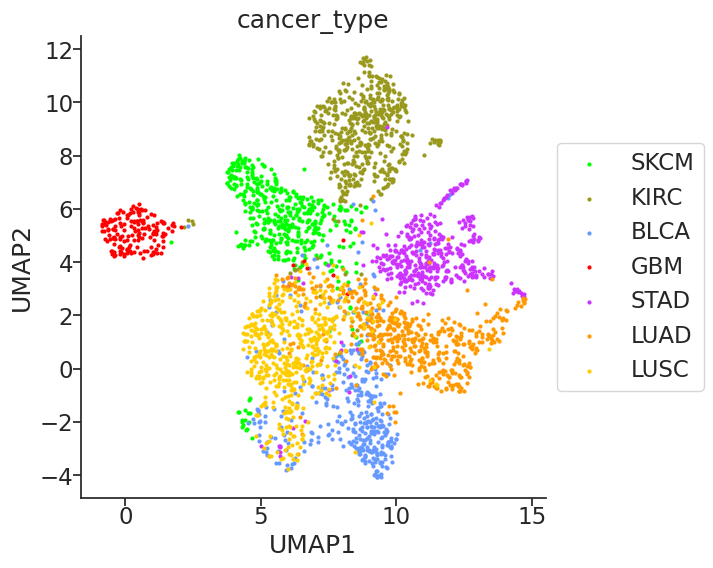

In [11]:
dfp = df_tpm.join(df_label.cancer_type)
figs = plot_embed_with_label(dfp,label_col=['cancer_type'], label_type=['c'], cmap = cancer_map,
                             orders = [cancer2plot], figsize=(6, 6),verbose=False)
fig, df2d = figs
fig[0].savefig('cancer_tcga_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_tcga_before_pretrain.csv')

100%|##########| 46/46 [00:03<00:00, 14.52it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


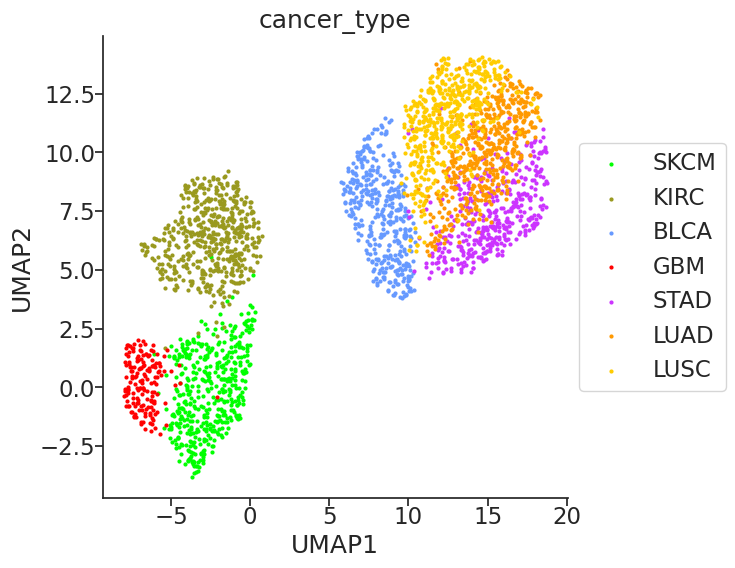

In [33]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame().join(df_tpm)
dfg, dfc = pretrainer.extract(dfcx, batch_size=64)
dfp1 = dfc[dfc.columns[:]].join(df_label.cancer_type)
figs1 = plot_embed_with_label(dfp1,label_col=['cancer_type'],label_type=['c'], n_neighbors=20, min_dist = 0.8, spread=1, random_state = 1,                             
                              orders = [cancer2plot], figsize=(6, 6), cmap= cancer_map, verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cancer_tcga_after_pretrain.pdf',bbox_inches ='tight')
df2d.to_csv('cancer_tcga_after_pretrain.csv')

## ITRP space, group by cancer

Before and After pretraining

In [13]:
itrp_data_path = '../../00_data/'

itrp_df_label = pd.read_pickle(os.path.join(itrp_data_path, 'ITRP.PATIENT.TABLE'))
itrp_df_tpm = pd.read_pickle(os.path.join(itrp_data_path, 'ITRP.TPM.TABLE'))
itrp_df_tpm = itrp_df_tpm[pretrainer.feature_name]

itrp_df_label.cohort = itrp_df_label.cancer_type +'_' + itrp_df_label.cohort.apply(lambda x:x.split('_')[0])
# cohort2plot = ['SKCM_Liu', 'SKCM_Gide', 'SKCM_Allen', 'SKCM_MGH', 'SKCM_Hugo',
#                'SKCM_Riaz', 'KIRC_Choueiri', 'KIRC_IMmotion150', 'KIRC_Miao',
#                'BLCA_IMVigor210', 'BLCA_Rose', 'BLCA_Snyder',
#                'GBM_Zhao', 'STAD_Kim',  'LUAD_Ravi']

# itrp_df_label = itrp_df_label[itrp_df_label.cohort.isin(cohort2plot)]
# itrp_df_tpm = itrp_df_tpm.loc[itrp_df_label.index]

In [14]:
itrp_df_label.cohort.unique()

array(['BLCA_IMVigor210', 'BLCA_Rose', 'BLCA_Snyder', 'GBM_Zhao',
       'KIRC_Choueiri', 'KIRC_IMmotion150', 'KIRC_Miao', 'LUAD_SU2CLC1',
       'LUSC_SU2CLC2', 'SKCM_Allen', 'SKCM_Gide', 'SKCM_Hugo', 'SKCM_Liu',
       'SKCM_MGH', 'SKCM_Riaz', 'STAD_Kim'], dtype=object)

In [15]:
itrp_df_label.columns

Index(['Sample_id', 'response_label', 'RECIST', 'Timing', 'cohort',
       'cancer_type', 'sequencer', 'ICI', 'ICI_target', 'Tissue',
       ...
       'BR', 'RECIST_Response', 'Mutational Subtype', 'participant',
       'ICI_target_map', 'ICI_map', 'Biopsy_site', 'sub_cohort',
       'sub_cohort_used_flag', 'real_TMB'],
      dtype='object', length=110)

In [16]:
dfp = itrp_df_tpm.join(itrp_df_label.cancer_type)
dfp.groupby('cancer_type').size()

cancer_type
BLCA    408
GBM      25
KIRC    198
LUAD    102
LUSC     25
SKCM    330
STAD     45
dtype: int64

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


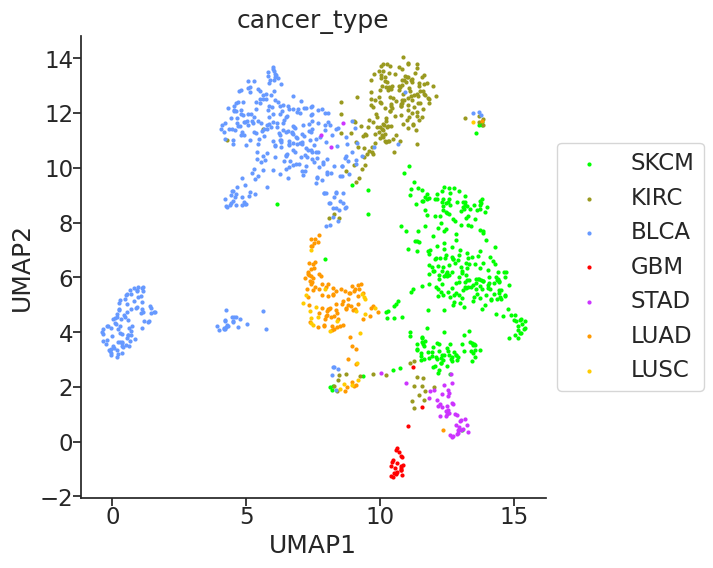

In [17]:
dfp = itrp_df_tpm.join(itrp_df_label.cancer_type)
figs = plot_embed_with_label(dfp,label_col=['cancer_type'],label_type=['c'], cmap = cancer_map,
                             orders = [cancer2plot], figsize=(6, 6), verbose=False)
fig, df2d = figs
fig[0].savefig('cancer_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_itrp_before_pretrain.csv')

100%|##########| 9/9 [00:01<00:00,  6.60it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


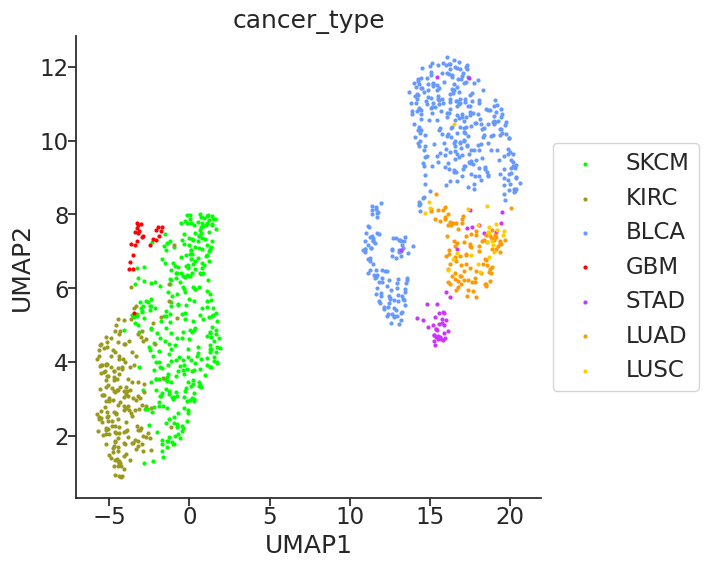

In [34]:
dfcx = itrp_df_label.cancer_type.map(CANCER_CODE).to_frame().join(itrp_df_tpm)
dfg, dfc = pretrainer.extract(dfcx, batch_size=128)
dfp1 = dfc[dfc.columns[:]].join(itrp_df_label.cancer_type)
figs1 = plot_embed_with_label(dfp1,label_col=['cancer_type'],label_type=['c'],cmap = cancer_map, metric='correlation', 
                              orders = [cancer2plot], figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('cancer_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_itrp_after_pretrain.csv')

In [19]:
dfc

,CANCER,Bcell_general,Memory_Bcell,Naive_Bcell,Plasma_cell,CD4_Tcell,CD8_Tcell,Memory_Tcell,Naive_Tcell,Tcell_general,...,Pancreatic,Pneumocyte,Apoptosis_pathway,IFNg_pathway,TGFb_pathway,Cytokine,Cell_proliferation,TLS,Genome_integrity,Reference
Index,,,,,,,,,,,,,,,,,,,,,
IMVigor210-0257bb-ar-0257bbb,2.231586,-0.389229,0.231750,-0.825250,-0.081168,0.000709,0.111215,0.110647,0.195162,-0.184545,...,0.035796,-0.031881,0.184865,-0.094043,-0.044376,-0.080585,0.012584,-0.187580,0.247796,0.473074
IMVigor210-025b45-ar-025b45c,2.231571,-0.270790,0.156105,-0.840884,-0.006839,-0.164405,0.076903,0.185160,0.377657,-0.227987,...,-0.101264,-0.009507,0.168403,-0.174539,0.150748,-0.050994,-0.130951,-0.140836,0.168329,0.472868
IMVigor210-032c64-ar-032c642,2.231654,-0.407526,0.317372,-0.815864,-0.252866,0.033699,0.095141,0.193900,0.275460,0.050045,...,0.059115,-0.030626,0.208292,0.116351,0.044724,-0.121553,0.098186,-0.162292,0.293963,0.474626
IMVigor210-0571f1-ar-0571f17,2.231629,-0.355616,0.539397,-0.460096,-0.120175,-0.203625,0.238796,0.223926,0.783757,0.473184,...,0.057428,0.033854,0.082151,0.111037,-0.039122,-0.101680,0.009289,0.399589,0.231508,0.467824
IMVigor210-065890-ar-0658907,2.231627,-0.385566,0.345579,-0.828408,-0.313886,0.008070,0.087979,0.079748,0.233385,-0.063662,...,0.153688,0.017908,0.252322,-0.001932,-0.115632,-0.087603,-0.049650,-0.234322,0.233928,0.479480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kim_NatMed_2018-p664-ar-026,1.627476,-0.272759,0.180004,-0.807862,-0.383983,0.077301,0.030158,0.017375,-0.069861,-0.101716,...,0.016761,-0.065509,0.041005,-0.065290,-0.087939,-0.049174,-0.091087,-0.132605,0.054446,0.474288
Kim_NatMed_2018-p666-ar-029,1.627506,-0.284941,0.273865,-0.814370,-0.385414,0.283738,0.010870,-0.014726,0.322328,0.052202,...,0.075509,-0.026758,-0.083573,-0.100718,0.019256,-0.085553,-0.190958,-0.073337,0.060160,0.459007
Kim_NatMed_2018-p667-ar-030,1.627466,-0.246364,0.165130,-0.819948,0.014665,0.053844,0.020811,-0.026382,-0.277332,-0.149911,...,-0.062757,-0.072609,0.023383,-0.108086,0.056649,-0.057156,-0.108659,-0.045827,0.017418,0.469578


## ITRP space, group by Target

Before and After pretraining

In [20]:
color_nan = '#cccccc'
target_order = [ 'PD1',  'PD1+CTLA4', 'PDL1',  'CTLA4', 'Other']
target_color = list(sns.color_palette("Set2", 4).as_hex())
target_color.append(color_nan)
#target_color = [colors[0], colors[3], '#00af89', colors[7],  colors[9]]
target_map = dict(zip(target_order, target_color))

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


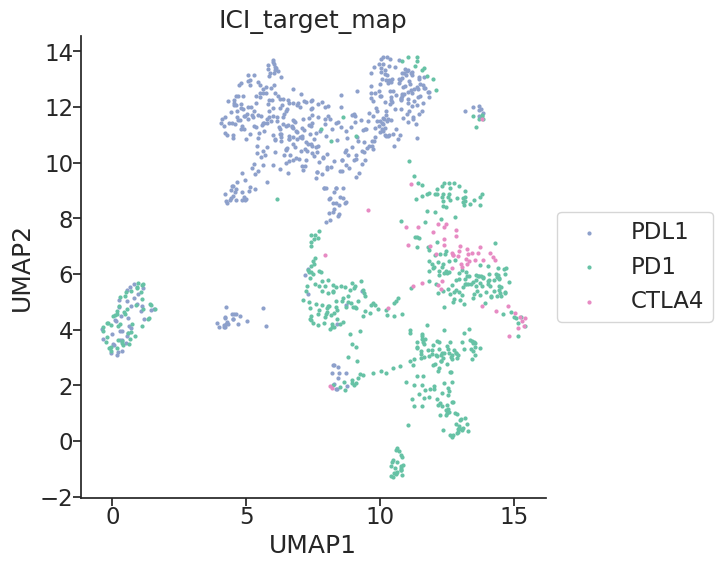

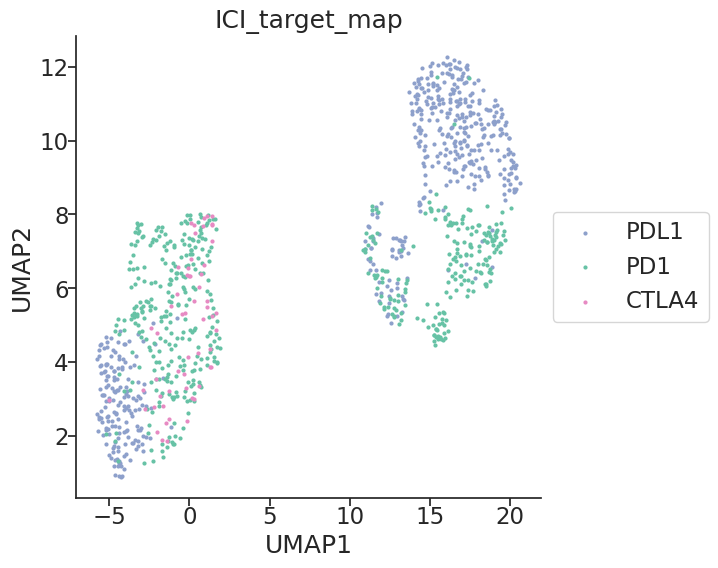

In [21]:
ici_target_order = ['PDL1', 'PD1', 'CTLA4', ]#'PD1 + CTLA4'
dfp1 = itrp_df_tpm.join(itrp_df_label['ICI_target_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_target_map'],label_type=['c'], cmap = target_map,
                              orders = [ici_target_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('target_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('target_itrp_before_pretrain.csv')

dfp1 = dfc[dfc.columns[:]].join(itrp_df_label['ICI_target_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_target_map'],label_type=['c'], cmap = target_map,
                              orders = [ici_target_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('target_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('target_itrp_after_pretrain.csv')


## ITRP space, group by Drug

Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


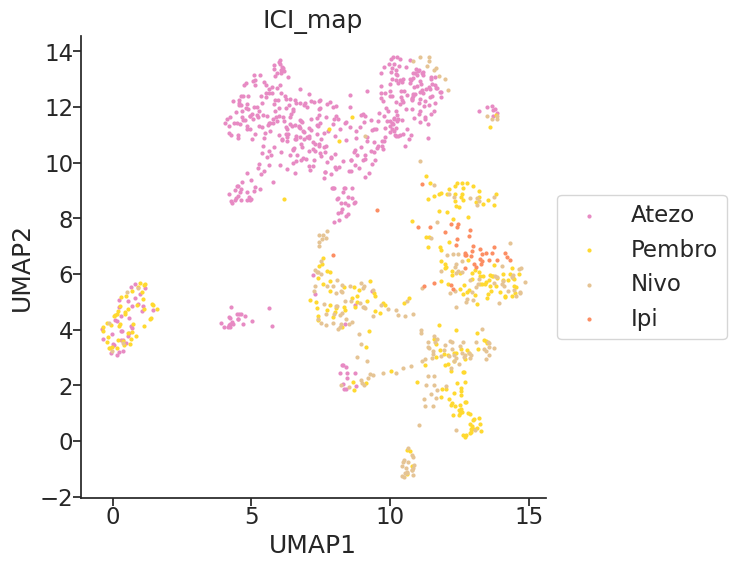

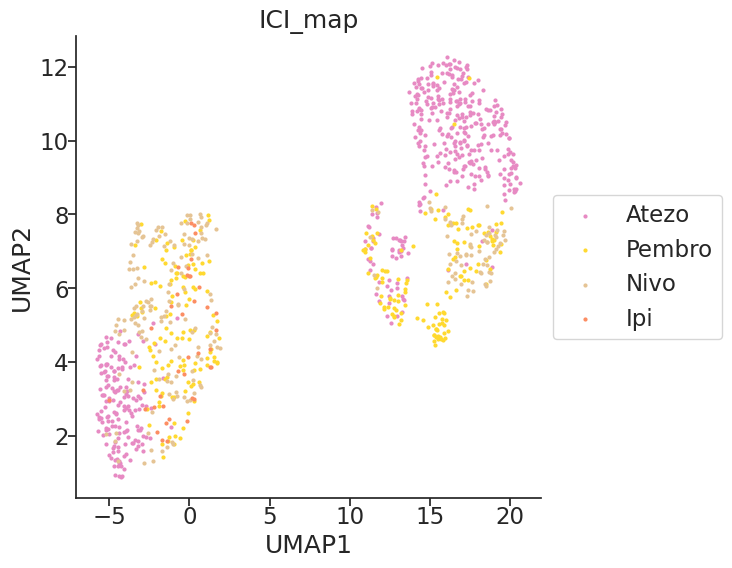

In [22]:
drug_order = [ 'Nivo', 'Pembro', 'Atezo', 'Comb.', 'Ipi',  'NA']
drug_color = list(sns.color_palette("Set2_r", 5).as_hex())
drug_color.append(color_nan)

drug_map = dict(zip(drug_order, drug_color))


ici_order = ['Atezo','Pembro', 'Nivo', 'Ipi']

dfp1 = itrp_df_tpm.join(itrp_df_label['ICI_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_map'],label_type=['c'],cmap = drug_map,
                              orders = [ici_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('drug_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('drug_itrp_before_pretrain.csv')


dfp1 = dfc[dfc.columns[:]].join(itrp_df_label['ICI_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_map'],label_type=['c'],cmap = drug_map,
                              orders = [ici_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('drug_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('drug_itrp_after_pretrain.csv')

# ITRP space, group by Sequencer
Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


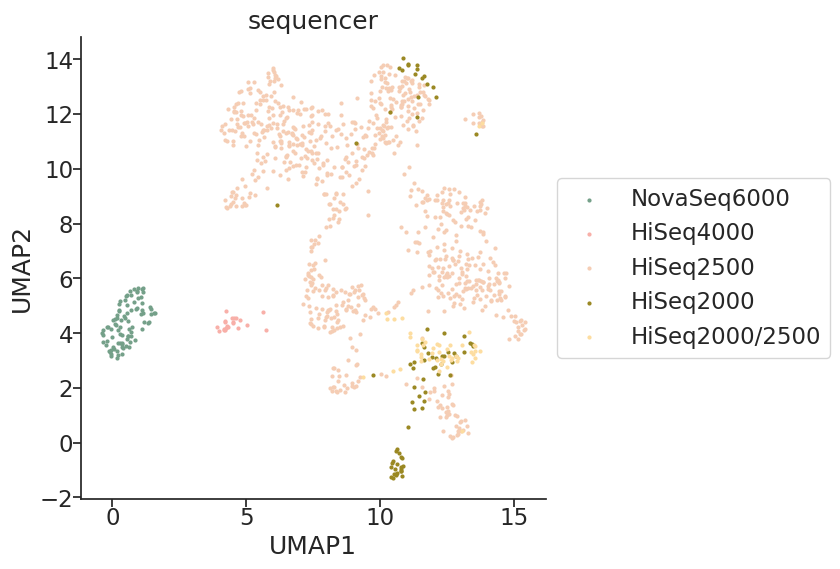

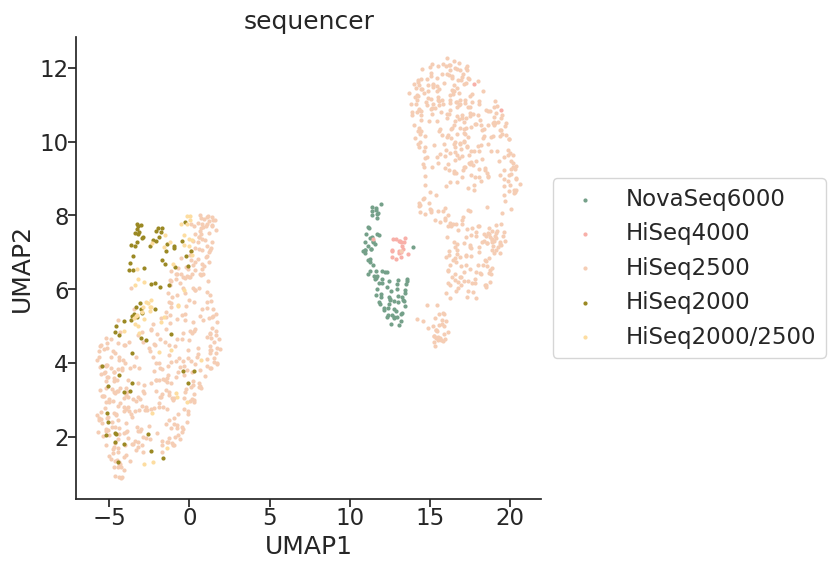

In [23]:
sequencer_order = ['HiSeq2000', 'HiSeq2500', 'HiSeq4000', 'HiSeq2000/2500',  'NovaSeq6000']
sequencer_color = cbm.palettes.royal2 #[colors[0], colors[3], colors[1], colors[6],  colors[-6]]
sequencer_map = dict(zip(sequencer_order, sequencer_color))


sequencer_order = ['NovaSeq6000', 'HiSeq4000', 'HiSeq2500', 'HiSeq2000', 'HiSeq2000/2500']
dfp1 = itrp_df_tpm.join(itrp_df_label['sequencer'])
figs1 = plot_embed_with_label(dfp1,label_col=['sequencer'],label_type=['c'], cmap=sequencer_map,
                              orders = [sequencer_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('sequencer_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('sequencer_itrp_before_pretrain.csv')

sequencer_order = ['NovaSeq6000', 'HiSeq4000', 'HiSeq2500', 'HiSeq2000', 'HiSeq2000/2500']
dfp1 = dfc[dfc.columns[:]].join(itrp_df_label['sequencer'])
figs1 = plot_embed_with_label(dfp1,label_col=['sequencer'],label_type=['c'], cmap=sequencer_map,
                              orders = [sequencer_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('sequencer_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('sequencer_itrp_after_pretrain.csv')

In [24]:
cohort2plot = [
                
 'SKCM_Hugo',
 'SKCM_Riaz',
 'SKCM_Gide',
 'SKCM_MGH',
 'SKCM_Liu',
 'SKCM_Allen',

'LUSC_SU2CLC2',
 'LUAD_SU2CLC1',

    
'KIRC_IMmotion150',
 'KIRC_Choueiri',
 'KIRC_Miao',
 

 'BLCA_IMVigor210',
 'BLCA_Rose',
 'BLCA_Snyder',
    
 'GBM_Zhao',
 'STAD_Kim']

In [25]:
import colorcet as cc
cohort_color = sns.color_palette(cc.glasbey, n_colors= len(cohort2plot))
cohort_map = dict(zip(cohort2plot, cohort_color))

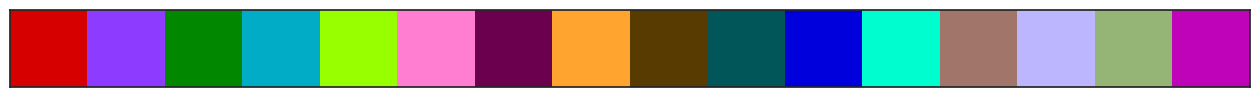

In [26]:
palette = sns.color_palette(cc.glasbey, n_colors= len(cohort2plot))
sns.palplot(palette)

In [27]:
# dfpa = pd.DataFrame(list(palette))
# from sklearn.decomposition import PCA
# from umap import UMAP
# mp = UMAP(n_components=1, n_neighbors=5)
# d1 = mp.fit_transform(dfpa)
# idx = pd.Series(d1.reshape(-1,)).sort_values().index

# dfpa = dfpa.iloc[idx]
# palette = dfpa.values.tolist()
# sns.palplot(palette)


In [28]:
#palette

## ITRP space, group by cohort

Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


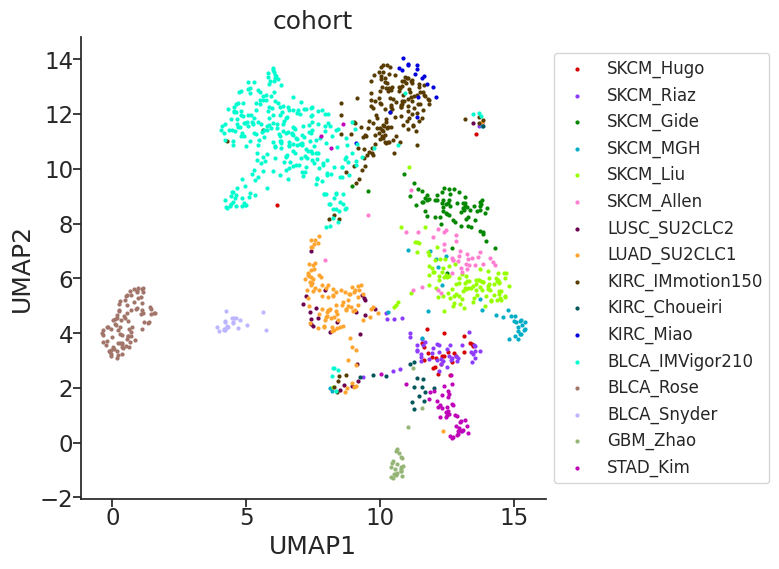

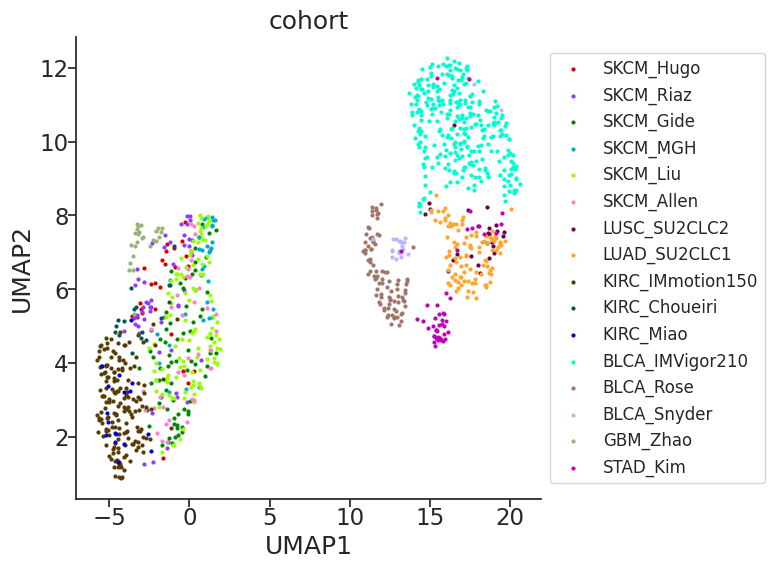

In [29]:
import colorcet as cc
cohort_color = sns.color_palette(cc.glasbey, n_colors= len(cohort2plot))

dfp0 = itrp_df_tpm.join(itrp_df_label.cohort)
figs1 = plot_embed_with_label(dfp0,label_col=['cohort'],label_type=['c'], cmap = cohort_color,
                              orders = [cohort2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cohort_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cohort_itrp_before_pretrain.csv')

dfp1 = dfc[dfc.columns[:]].join(itrp_df_label.cohort)
figs1 = plot_embed_with_label(dfp1,label_col=['cohort'],label_type=['c'], cmap = cohort_color,
                              orders = [cohort2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cohort_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cohort_itrp_after_pretrain.csv')